In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np

import statsmodels as sm
import seaborn as sns

import matplotlib.pyplot as plt
from math import ceil

In [3]:
! pip install -U imbalanced-learn

     |████████████████████████████████| 163kB 2.8MB/s 
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


# Data Treatment
## 1) Adult Data

In [0]:
from sklearn.datasets import fetch_openml

In [0]:
df, y = fetch_openml('adult', version=2, as_frame=True, return_X_y=True)
# we are dropping the following features:
# - "fnlwgt": this feature was created while studying the "adult" dataset.
#   Thus, we will not use this feature which is not acquired during the survey.
# - "education-num": it is encoding the same information than "education".
#   Thus, we are removing one of these 2 features.
original_data = df.drop(columns=['fnlwgt', 'education-num'])

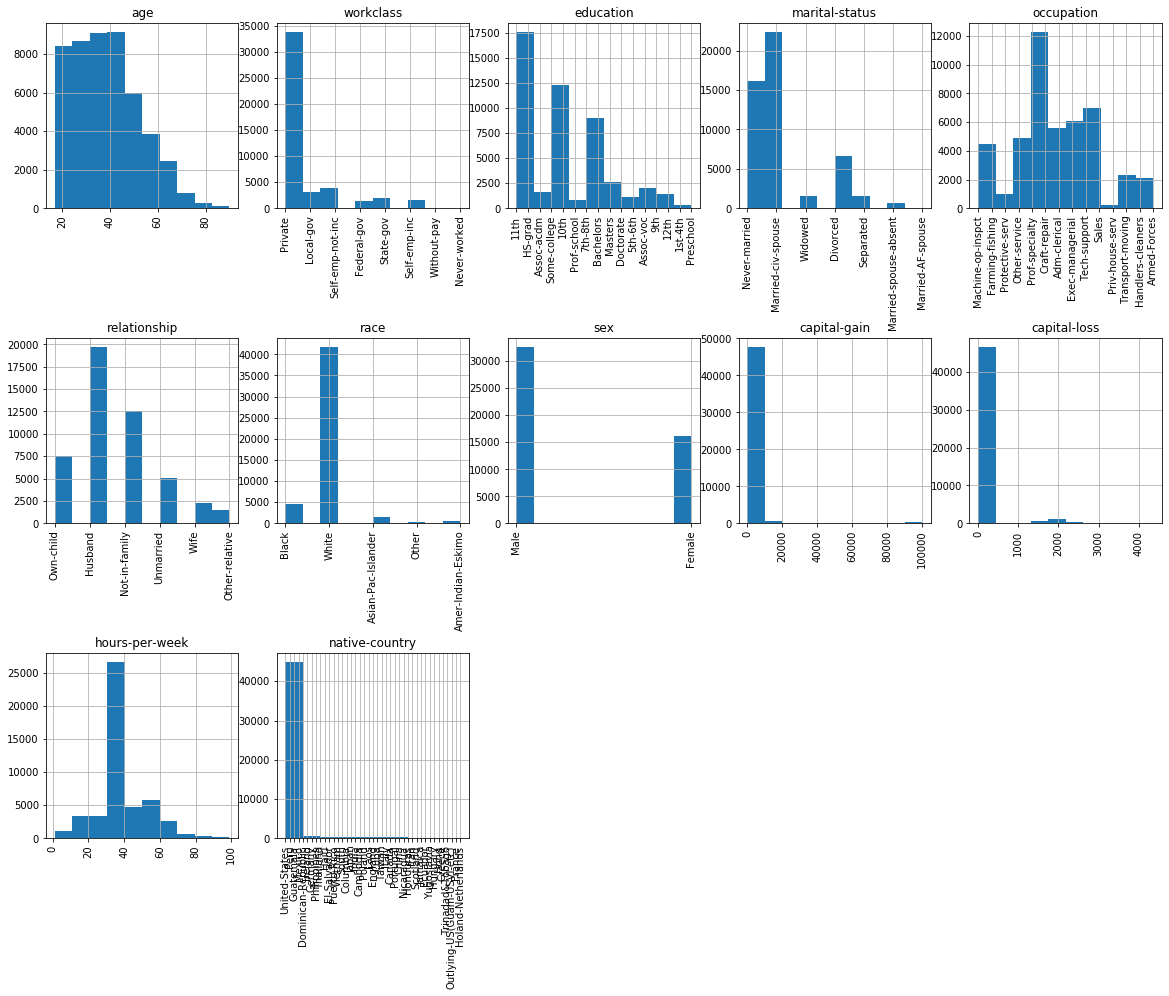

In [6]:
fig = plt.figure(figsize=(20,15))
cols = 5
rows = ceil(float(original_data.shape[1]) / cols)
for i, column in enumerate(original_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if original_data.dtypes[column] == np.object:
        original_data[column].value_counts().plot(kind="bar", axes=ax)
    else:
        original_data[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [0]:
original_data.to_csv("/content/drive/My Drive/Colab Notebooks/data/adult.csv", index = False)

## Credit card fraud data

In [0]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/creditcard.csv")
### Time dependency 제거
df = df.drop('Time', axis = 1)

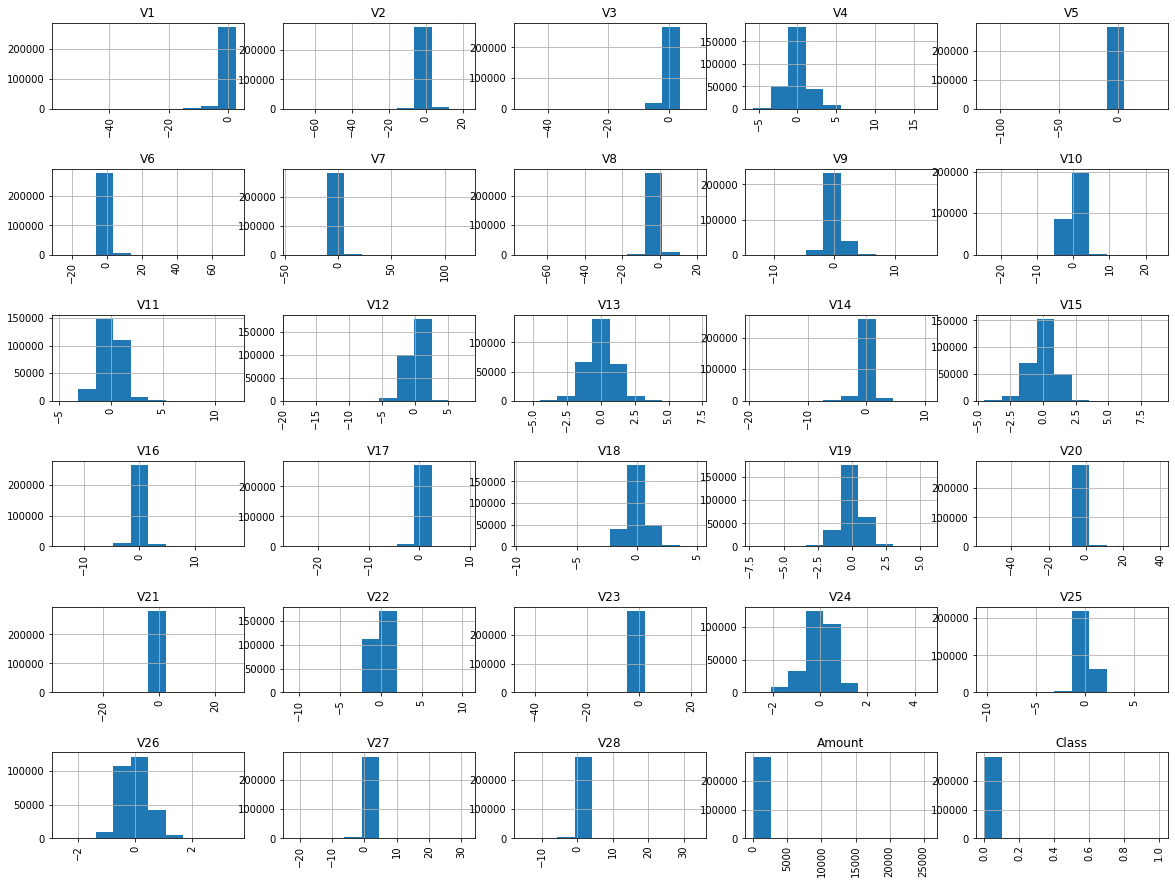

In [9]:
fig = plt.figure(figsize=(20,15))
cols = 5
rows = ceil(float(df.shape[1]) / cols)
for i, column in enumerate(df.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if df.dtypes[column] == np.object:
        df[column].value_counts().plot(kind="bar", axes=ax)
    else:
        df[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

# Experiment 1. Adult Data

In [0]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/adult.csv")

In [11]:
df

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,NaN,Some-college,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States
48838,40.0,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States
48839,58.0,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States
48840,22.0,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States


In [12]:
df.workclass.unique()

array(['Private', 'Local-gov', nan, 'Self-emp-not-inc', 'Federal-gov',
       'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [13]:
###############################################################################
# The "adult" dataset as a class ratio of about 3:1

classes_count = y.value_counts()
classes_count

<=50K    37155
>50K     11687
Name: class, dtype: int64

In [14]:
###############################################################################
# This dataset is only slightly imbalanced. To better highlight the effect of
# learning from an imbalanced dataset, we will increase its ratio to 30:1

from imblearn.datasets import make_imbalance

Using TensorFlow backend.


In [0]:
ratio = 100
df_res, y_res = make_imbalance(
    df, y, sampling_strategy={
        classes_count.idxmin(): classes_count.max() // ratio
    }
)

In [16]:
y_res.value_counts()

<=50K    37155
>50K       371
Name: class, dtype: int64

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

In [0]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import balanced_accuracy_score

def evaluate_classifier(clf, df_scores, clf_name=None):
    acc_list = []
    bal_acc_list = []
    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 
    for train_index, test_index in kfold.split(df_res):
        X_train, X_test = df_res.iloc[train_index], df_res.iloc[test_index]
        y_train, y_test = y_res.iloc[train_index], y_res.iloc[test_index]
#         X_train, X_test = X_train.values, X_test.values
        acc = clf.fit(X_train, y_train).score(X_test, y_test)
        y_pred = clf.predict(X_test)
        bal_acc = balanced_accuracy_score(y_test, y_pred)
        
        acc_list.append(acc)
        bal_acc_list.append(bal_acc)
    
    cv_acc = np.mean(acc_list)
    cv_bal_acc = np.mean(bal_acc_list)
    clf_score = pd.DataFrame(
        {clf_name: [cv_acc, cv_bal_acc]},
        index=['Accuracy', 'Balanced accuracy']
    )
    df_scores = pd.concat([df_scores, clf_score], axis=1).round(decimals=3)
    return df_scores

In [0]:
# Let's define an empty dataframe to store the results
df_scores = pd.DataFrame()

In [20]:
###############################################################################
# As a baseline, we could use a classifier which will always predict the
# majority class independently of the features provided.

from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
df_scores = evaluate_classifier(dummy_clf, df_scores, "Dummy")
df_scores

,Dummy
Accuracy,0.99
Balanced accuracy,0.50


### LR and RF

In [0]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

In [0]:
###############################################################################
# Then, we can create a preprocessor which will dispatch the categorical
# columns to the categorical pipeline and the numerical columns to the
# numerical pipeline

num_pipe = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)

cat_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessor = ColumnTransformer(
    [("num-pipe", num_pipe, selector(dtype_include=np.number)),
     ("cat-pipe", cat_pipe, selector(dtype_include=pd.CategoricalDtype))],
    n_jobs=2
)

In [23]:
###############################################################################
# Finally, we connect our preprocessor with our `LogisticRegression`. We can
# then evaluate our model.

from sklearn.linear_model import LogisticRegression

lr_clf = make_pipeline(
    preprocessor, LogisticRegression(max_iter=1000)
)
df_scores = evaluate_classifier(lr_clf, df_scores, "LR")
df_scores

from sklearn.ensemble import RandomForestClassifier



preprocessor = ColumnTransformer(
    [("num-pipe", num_pipe, selector(dtype_include=np.number)),
     ("cat-pipe", cat_pipe, selector(dtype_include=pd.CategoricalDtype))],
    n_jobs=2
)

rf_clf = make_pipeline(
    preprocessor, RandomForestClassifier(random_state=42, n_jobs=2)
)

df_scores = evaluate_classifier(rf_clf, df_scores, "RF")
df_scores

,Dummy,LR,RF
Accuracy,0.99,0.990,0.992
Balanced accuracy,0.50,0.519,0.603


### pipeline with sampling

In [24]:
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from imblearn.under_sampling import RandomUnderSampler

lr_clf = make_pipeline_with_sampler(
    preprocessor,
    RandomUnderSampler(random_state=42),
    LogisticRegression(max_iter=1000)
)
df_scores = evaluate_classifier(
    lr_clf, df_scores, "LR with random under-sampling"
)
df_scores

###############################################################################
#

rf_clf = make_pipeline_with_sampler(
    preprocessor,
    RandomUnderSampler(random_state=42),
    RandomForestClassifier(random_state=42, n_jobs=2)
)

df_scores = evaluate_classifier(
    rf_clf, df_scores, "RF with random under-sampling"
)
df_scores

,Dummy,LR,RF,LR with random under-sampling,RF with random under-sampling
Accuracy,0.99,0.990,0.992,0.723,0.693
Balanced accuracy,0.50,0.519,0.603,0.671,0.692


In [25]:
from imblearn.under_sampling import TomekLinks

lr_clf = make_pipeline_with_sampler(
    preprocessor,
    TomekLinks(),
    LogisticRegression(max_iter=1000)
)
df_scores = evaluate_classifier(
    lr_clf, df_scores, "LR with TomekLinks under-sampling"
)
df_scores

###############################################################################
#

rf_clf = make_pipeline_with_sampler(
    preprocessor,
    TomekLinks(),
    RandomForestClassifier(random_state=42, n_jobs=2)
)

df_scores = evaluate_classifier(
    rf_clf, df_scores, "RF with TomekLinks under-sampling"
)
df_scores

,Dummy,LR,RF,LR with random under-sampling,RF with random under-sampling,LR with TomekLinks under-sampling,RF with TomekLinks under-sampling
Accuracy,0.99,0.990,0.992,0.723,0.693,0.990,0.992
Balanced accuracy,0.50,0.519,0.603,0.671,0.692,0.519,0.607


In [26]:
from imblearn.over_sampling import RandomOverSampler

lr_clf = make_pipeline_with_sampler(
    preprocessor,
    RandomOverSampler(random_state=42),
    LogisticRegression(max_iter=1000)
)
df_scores = evaluate_classifier(
    lr_clf, df_scores, "LR with random over-sampling"
)
df_scores

###############################################################################
#

rf_clf = make_pipeline_with_sampler(
    preprocessor,
    RandomOverSampler(random_state=42),
    RandomForestClassifier(random_state=42, n_jobs=2)
)

df_scores = evaluate_classifier(
    rf_clf, df_scores, "RF with random over-sampling"
)
df_scores

,Dummy,LR,RF,LR with random under-sampling,RF with random under-sampling,LR with TomekLinks under-sampling,RF with TomekLinks under-sampling,LR with random over-sampling,RF with random over-sampling
Accuracy,0.99,0.990,0.992,0.723,0.693,0.990,0.992,0.730,0.818
Balanced accuracy,0.50,0.519,0.603,0.671,0.692,0.519,0.607,0.677,0.665


In [27]:
from imblearn.over_sampling import SMOTE

lr_clf = make_pipeline_with_sampler(
    preprocessor,
    SMOTE(random_state=42),
    LogisticRegression(max_iter=1000)
)
df_scores = evaluate_classifier(
    lr_clf, df_scores, "LR with SMOTE"
)
df_scores

###############################################################################
#

rf_clf = make_pipeline_with_sampler(
    preprocessor,
    SMOTE(random_state=42),
    RandomForestClassifier(random_state=42, n_jobs=2)
)

df_scores = evaluate_classifier(
    rf_clf, df_scores, "RF with SMOTE"
)
df_scores

,Dummy,LR,RF,LR with random under-sampling,RF with random under-sampling,LR with TomekLinks under-sampling,RF with TomekLinks under-sampling,LR with random over-sampling,RF with random over-sampling,LR with SMOTE,RF with SMOTE
Accuracy,0.99,0.990,0.992,0.723,0.693,0.990,0.992,0.730,0.818,0.730,0.903
Balanced accuracy,0.50,0.519,0.603,0.671,0.692,0.519,0.607,0.677,0.665,0.678,0.636


In [28]:
from imblearn.combine import SMOTEENN, SMOTETomek

lr_clf = make_pipeline_with_sampler(
    preprocessor,
    SMOTETomek(random_state=42),
    LogisticRegression(max_iter=1000)
)
df_scores = evaluate_classifier(
    lr_clf, df_scores, "LR with SMOTE-Tomek"
)
df_scores

###############################################################################
#

rf_clf = make_pipeline_with_sampler(
    preprocessor,
    SMOTETomek(random_state=42),
    RandomForestClassifier(random_state=42, n_jobs=2)
)

df_scores = evaluate_classifier(
    rf_clf, df_scores, "RF with SMOTE-Tomek"
)
df_scores

lr_clf = make_pipeline_with_sampler(
    preprocessor,
    SMOTEENN(random_state=42),
    LogisticRegression(max_iter=1000)
)
df_scores = evaluate_classifier(
    lr_clf, df_scores, "LR with SMOTE-ENN"
)
df_scores

###############################################################################
#

rf_clf = make_pipeline_with_sampler(
    preprocessor,
    SMOTEENN(random_state=42),
    RandomForestClassifier(random_state=42, n_jobs=2)
)

df_scores = evaluate_classifier(
    rf_clf, df_scores, "RF with SMOTE-ENN"
)
df_scores

,Dummy,LR,RF,LR with random under-sampling,RF with random under-sampling,LR with TomekLinks under-sampling,RF with TomekLinks under-sampling,LR with random over-sampling,RF with random over-sampling,LR with SMOTE,RF with SMOTE,LR with SMOTE-Tomek,RF with SMOTE-Tomek,LR with SMOTE-ENN,RF with SMOTE-ENN
Accuracy,0.99,0.990,0.992,0.723,0.693,0.990,0.992,0.730,0.818,0.730,0.903,0.730,0.903,0.850,0.979
Balanced accuracy,0.50,0.519,0.603,0.671,0.692,0.519,0.607,0.677,0.665,0.678,0.636,0.678,0.642,0.666,0.624


In [29]:
from imblearn.ensemble import BalancedRandomForestClassifier

rf_clf = make_pipeline(
    preprocessor,
    BalancedRandomForestClassifier(random_state=42, n_jobs=2)
)

df_scores = evaluate_classifier(rf_clf, df_scores, "Balanced RF")
df_scores

,Dummy,LR,RF,LR with random under-sampling,RF with random under-sampling,LR with TomekLinks under-sampling,RF with TomekLinks under-sampling,LR with random over-sampling,RF with random over-sampling,LR with SMOTE,RF with SMOTE,LR with SMOTE-Tomek,RF with SMOTE-Tomek,LR with SMOTE-ENN,RF with SMOTE-ENN,Balanced RF
Accuracy,0.99,0.990,0.992,0.723,0.693,0.990,0.992,0.730,0.818,0.730,0.903,0.730,0.903,0.850,0.979,0.682
Balanced accuracy,0.50,0.519,0.603,0.671,0.692,0.519,0.607,0.677,0.665,0.678,0.636,0.678,0.642,0.666,0.624,0.718


In [0]:
adult_result = df_scores

In [0]:
adult_result.to_csv("/content/drive/My Drive/Colab Notebooks/data/adult_result.csv")